# Assignment 2, Data Science for Design 2017
### Muhamad Iqbal, s1635468

### Bot on twitter during Brexit

During the brexit, many people talk about it through social media. one social media platform that was used by people is twitter. usually, this platform is used by the researcher as their data sources. furthermore, they use it to identify the social condition like expectation and preception about some topic, in this case is Brexit.

Before we gain insight about something using twitter data. can we trust this data source to identify social behaviour? Since there is not only human that sharing their idea through this platform. but also A bot. Based on BotOMeter researcher, Emilio Ferrara, Ph.D, explained, “We found that approximately 15% of the users active in the political conversation one month prior to the 2016 election were likely bots… and they were responsible to about one in five such political tweets (nearly 20%).”*. Commonly, this bot was created by human to achieve the bot creator purpose, such as spamming and influencing the social media to create perception about something. 

If we want to talk about people perception by using twitter data. Should we exclude the bot from the dataset? but they might taking part on shaping people perception.

the main analysis on this notebook to identify the number of bots from twitter data. and also to identify what sentiment being brought by the bot. 

source:
- "Social  Twitter  bots  fake news Bot-hunting Twitter bot sniffs out bogus political tweets"
https://techcrunch.com/2017/10/25/botometer-twitter-bot-hunting-probabot/


<h1>Data Description and Preparation</h1>
<h3>Data Preparation #1: Import twitter data</h3>

The data used in this project are tweets exported from Twitter in the context of the UK brexit.<br/>
The data are generated from the following hashtags: #eureferendum, #euref, #brexit, #no2eu, #yes2eu, #notoeu, #yestoeu, #betteroffout, #betteroffin, #voteout, #votein, #eureform, #ukineu, #Bremain ,#EUpoll, #UKreferendum, #UKandEU, #EUpol, #ImagineEurope, #EdEUref, #MyImageOfTheEU #eu, #referendum, #europe, #UKRef, #ref, #migrant, #refugee #strongerin, #leadnotleave, #voteremain, #britainout, '#leaveeu, #voteleave, #beleave, #loveeuropeleaveeu, #greenerin, #britin, #eunegotiation, #eurenegotiation, #grassrootsout, #projectfear, #projectfact, #remaineu, #europeanunion, #brexitfears, #remain, #leave, #takecontrol, #euinorout, #leavechaos, #labourin, #conservatives, #bregret, #brexitvote, #brexitin5words, #labourcoup, #eurefresults, #projectfear, #VoteLeaveLoseControl, #regrexit, #wearethe48, #scexit, #niineurope, #scotlandineurope, #article50, #scotlandineu

The generated data are stored as JSON files. In total they are approximately 18GB of compressed Tar files.

The dataset is collected on 5 days around brexit.

- 21 June 2016
- 22 June 2016
- 23 June 2016
- 22 September 2017
- 23 September 2017

For each day there are JSON files for tweets about brexit collected every hour in 24 hours.
Each JSON files varies with one another in size, ranging from 4MB in to 500MB.

In this notebook, we use only one hour time frame on 22 September 2017 between 12 AM to 13 PM.

In [1]:
%matplotlib inline

import tarfile
import json
import gzip
import pandas as pd
import re
from textblob import TextBlob
from pandas.io.json import json_normalize
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

tar = tarfile.open("../input/2017-09-22.tar.gz", "r:gz")
data = pd.DataFrame()
count=0

'''
        Extracting from twitter data.
'''

for members in tar.getmembers():
    if (count==13):
        f = tar.extractfile(members)
        data = data.append(pd.read_json(f, lines=True))
    count = count + 1

/Users/ikibozu/miniconda2/envs/mlp/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
print("number of rows :", data.shape[0])
print("number of column :",data.shape[1])
print("")
print("raw twitter data columns :")
print("")
print(data.iloc[0])

('number of rows :', 4369)
('number of column :', 36)

raw twitter data columns :

contributors                                                               NaN
coordinates                                                               None
created_at                                                 2017-09-22 12:05:02
display_text_range                                                    [0, 140]
entities                     {u'user_mentions': [], u'symbols': [], u'hasht...
extended_entities                                                          NaN
extended_tweet               {u'display_text_range': [0, 135], u'entities':...
favorite_count                                                               0
favorited                                                                False
filter_level                                                               low
geo                                                                       None
id                                              

<h2>Column Selection</h2>

Not all of the column is used on this analysis. Since we want to know which account bot, I decided to choose column "screen_name" so I could find analysis this account by using BotOMeter API. and also, I picked "retweet_count", "reply_count", "quote_count", and "retweeted_status" columns to know whether this account got feedback from other users. and column "created_at" to know time series of the data. and extracting hashtag to know which hashtag was being trend during that time. and also lang, to identify language being used by the twitter user.

In [3]:
'''
        Compiling hashtags result.
'''
count=0
hashtags=[]
for ent in data['entities']:
    str_hsh=''
    for hsh in ent['hashtags']:
        #print(hsh['text'])
        str_hsh=hsh['text']+';'+str_hsh
    hashtags.append(str_hsh.upper())
    count = count+1
    
'''
        Compiling user screen_name result.
'''
namelist=[]
for x in data['user']:
    namelist.append(x['screen_name'])

twt_data=pd.DataFrame({'screen_name':namelist, 'lang':data['lang'] 
                            ,'retweet_count':data['retweet_count']
                            ,'reply_count':data['reply_count']
                            ,'quote_count':data['quote_count']
                            ,'retweeted_status':data['retweeted_status']
                            ,'hashtags':hashtags
                            ,'created_at':data['created_at']
                           })

In [4]:
twt_data.head()

,created_at,hashtags,lang,quote_count,reply_count,retweet_count,retweeted_status,screen_name
0,2017-09-22 12:05:02,EXCEL;LONDON;EUROPE;MRO;,en,0,0,0,NaN,allanwhyte81
1,2017-09-22 12:05:03,BREXIT;,en,0,0,0,"{u'quote_count': 1, u'contributors': None, u't...",blueghosties
2,2017-09-22 12:05:05,ASIE;EUROPE;SCOOTERS;,fr,0,0,0,NaN,83Kindy
3,2017-09-22 12:05:05,BREXIT;,en,0,0,0,NaN,WheezingWez
4,2017-09-22 12:05:05,CYBERSECURITY;EU;,en,0,0,0,NaN,abacohosting


<h3>Data Preparation #2: Import data from previous BotOMeter preprocessing </h3>

I used BotOMeter API To identify which twitter account is bot. This API investigating the account by using their machine learning system to extracts more than a thousand features in six different classes: users and friends meta-data, tweet content and sentiment, network patterns, and activity time series. I worked on diffrent notebook to get the bot score since this process takes long time to produce the result and dumped into "outputbot_[1:8].csv". So, in this notebook we only unload the csv file into dataframe.


botometer preprocessing notebook:
http://localhost:8888/notebooks/iqbal/bom_crawler.ipynb



BotOMeter documentation : 
- https://botometer.iuni.iu.edu/
- https://github.com/IUNetSci/botometer-python


Reference:
- Online Human-Bot Interactions: Detection, Estimation, and Characterization, Onur Varol Emilio Ferrara Clayton A. Davis Filippo Menczer Alessandro Flammini, ICWSM 2017.
src: https://aaai.org/ocs/index.php/ICWSM/ICWSM17/paper/view/15587/14817


In [5]:
bot_data = pd.DataFrame()
distinct_bot_data = ()

for i in range(1,8):
    output="outputbot_"+str(i)+".csv"
    bot_data=bot_data.append(pd.read_csv(output))
bot_data.head()

,Unnamed: 0,0,id_str,screen_name,0.1,english,universal,0.2,content,friend,network,sentiment,temporal,user
0,0.0,NaN,2.799616e+09,allanwhyte81,NaN,0.35,0.29,NaN,0.79,0.39,0.68,0.12,0.44,0.15
1,1.0,NaN,3.224059e+09,blueghosties,NaN,0.33,0.35,NaN,0.39,0.27,0.40,0.47,0.13,0.05
2,2.0,NaN,3.584310e+08,83Kindy,NaN,0.39,0.49,NaN,0.56,0.55,0.63,0.19,0.26,0.47
3,3.0,NaN,3.043517e+09,WheezingWez,NaN,0.22,0.18,NaN,0.27,0.20,0.33,0.11,0.38,0.06
4,4.0,NaN,1.774259e+08,abacohosting,NaN,0.45,0.40,NaN,0.68,0.58,0.64,0.76,0.37,0.30


<h2>Column Selection</h2>

I chosed column "screen_name" to set is as foreign key so I could join it with twitter data. and also the data itself is distincted  by screen_name. and also I used "englsih" column to identify their similiarness to the bot. the value for this colun is between 0.0 and 1.0.

In [6]:
#print(len(bot_data))
bot_data=bot_data[['screen_name','english']]
print("Data example :")
print(bot_data.head())
print("\n\nData description:")
print(bot_data.describe())

Data example :
    screen_name  english
0  allanwhyte81     0.35
1  blueghosties     0.33
2       83Kindy     0.39
3   WheezingWez     0.22
4  abacohosting     0.45


Data description:
           english
count  3120.000000
mean      0.373854
std       0.117017
min       0.040000
25%       0.290000
50%       0.360000
75%       0.450000
max       0.880000


<h3>Data Preparation #3: Import Sentiment based on Naive Bayes data</h3>

In order to get sentiment analysis, I used TextBlob API. This API using Naive Bayes Analyzer to identify sentiment on machine learning based on corpora movie review database. The output result of API is :
- Classification - either pos or neg indicating if the text is positive or negative, the value of this column is "neg" or "pos"
- P_Pos - a measure of how positive the text is between 0.0 and 1.0
- P_Neg - a measure of how negative the text is between 0.0 and 1.0

Since it takes long time on processing. I decided to work on different notebook and dump into "sentiment_output.csv".

http://localhost:8888/notebooks/iqbal/textblob_naivebayes_sentiment.ipynb

Documentation:
- https://textblob.readthedocs.io/en/dev/index.html


In [7]:
sentiment_data = pd.DataFrame()
sentiment_data = pd.read_csv("sentiment_output.csv")
sentiment_data = sentiment_data[["class","p_neg","p_pos"]]
sentiment_data[0:2]

,class,p_neg,p_pos
0,pos,0.005214,0.994786
1,pos,0.049174,0.950826


<h1>Data Merging: Merging the data sources</h1>

Joining the twitter data and the sentiment data, since this data is in the same order and has same rows. I decided to use join function.

In [8]:
sen_dat=twt_data.join(sentiment_data[['class','p_neg','p_pos']])

Joining the twitter data and the botometer data. I use 'screen_name" as key to join as left outer join with twitter data.

In [9]:
compiled_data=pd.merge(sen_dat,bot_data, how='left', on=['screen_name'])

compiled_data=compiled_data.rename(columns = {'english':'botometer'})
old_compiled_data=compiled_data
old_compiled_data=compiled_data

<h3>Data checking process: </h3>
Checking if the input and the data after joining has the same output. So there is no miss during join process.

In [10]:
assert (len(compiled_data)==len(data)), "Input data and output data has a different count"

<h1>Describing the Data</h1>


In [11]:
old_compiled_data.describe()

,quote_count,reply_count,retweet_count,p_neg,p_pos,botometer
count,4369.0,4369.0,4369.0,4369.000000,4369.000000,4202.000000
mean,0.0,0.0,0.0,0.324850,0.675150,0.387168
std,0.0,0.0,0.0,0.252613,0.252613,0.118586
min,0.0,0.0,0.0,0.000046,0.017756,0.040000
25%,0.0,0.0,0.0,0.108116,0.500000,0.300000
50%,0.0,0.0,0.0,0.268741,0.731259,0.380000
75%,0.0,0.0,0.0,0.500000,0.891884,0.460000
max,0.0,0.0,0.0,0.982244,0.999954,0.880000


In [12]:
old_compiled_data.iloc[0]

created_at               2017-09-22 12:05:02
hashtags            EXCEL;LONDON;EUROPE;MRO;
lang                                      en
quote_count                                0
reply_count                                0
retweet_count                              0
retweeted_status                         NaN
screen_name                     allanwhyte81
class                                    pos
p_neg                             0.00521412
p_pos                               0.994786
botometer                               0.35
Name: 0, dtype: object

<h3>Cleansing null value on column BotoMeter</h3>

When the column of this botometer is null, it's mean the account has been deactivated. This value will be filled by value 0.

In [13]:
compiled_data[pd.isnull(compiled_data['botometer'])==True][0:2]

,created_at,hashtags,lang,quote_count,reply_count,retweet_count,retweeted_status,screen_name,class,p_neg,p_pos,botometer
34,2017-09-22 12:05:39,MEDIA;EUROPE;UK;UAE;SAUDI;US;YEMEN;,en,0,0,0,"{u'quote_count': 1, u'contributors': [90222948...",Raihan_Abhari,pos,0.120222,0.879778,NaN
35,2017-09-22 12:05:39,WALKAWAYMAY;,en,0,0,0,"{u'quote_count': 0, u'contributors': None, u'q...",gnugaz,pos,0.464015,0.535985,NaN


In [14]:
print("there is null value on column botometer, this null indicated this account already deactivate their account :")
len(compiled_data[pd.isnull(compiled_data['botometer'])==True])

there is null value on column botometer, this null indicated this account already deactivate their account :


167

In [15]:
print("replacing null value to zero is done")
compiled_data['botometer']=compiled_data.botometer.replace(np.NaN, 0)
print("there is null value on column botometer, this null indicated this account already deactivate their account :")
len(compiled_data[pd.isnull(compiled_data['botometer'])==True])

replacing null value to zero is done
there is null value on column botometer, this null indicated this account already deactivate their account :


0

<h3>English Language tweet filtering</h3>

Since sentiment analysis is used by english language, I decided to excluded non-english language.

In [16]:
check=compiled_data[['lang','quote_count']]
check=check.rename(columns = {'quote_count':'count'})
check.groupby(['lang'], sort=True, as_index=False).count().sort_values(by='count', ascending=False)

,lang,count
4,en,3348
27,und,423
5,es,151
8,fr,133
2,de,120
12,it,57
16,nl,49
19,pt,11
20,ro,8
9,ht,8


In [17]:
compiled_data=compiled_data[compiled_data['lang']=='en']
print("number of tweet that have non-english language :")
len(compiled_data[compiled_data['lang']!='en'])

number of tweet that have non-english language :


0

<h1>Analysis Part</h1>
<h3>Analysis 1: sentiment analysis of hashtags</h3>
Identifying sentiment analysis of hashtags by finding the sentiment value of tweet where the hashtag available. and then averaging the sentiment analysis. 

In [18]:
txt_tag=[]
sntment_tag=[]
for x in range(len(compiled_data)):
    oo=TextBlob(compiled_data.iloc[x]['hashtags']).words
    for p in oo:
        txt_tag.append(p)
        sntment_tag.append(compiled_data.iloc[x]['p_pos'])

hashtag_analysis=pd.DataFrame({
            'hashtag':txt_tag,
            'sentimenttag':sntment_tag
            })
hashtag_analysis[0:2]

,hashtag,sentimenttag
0,EXCEL,0.994786
1,LONDON,0.994786


In [19]:
avg=hashtag_analysis.groupby(['hashtag'], as_index=False).mean()
cnt=hashtag_analysis.groupby(['hashtag'], sort=True, as_index=False).count().sort_values(by='sentimenttag', ascending=False)

analysis1=pd.merge(avg,cnt, how='left', on=['hashtag'])
analysis1=analysis1.rename(columns = {
                            'sentimenttag_y':'count',
                            'sentimenttag_x':'p_pos'
                           })
analysis1=analysis1.sort_values(by=['count'], ascending=False)[0:10]
analysis1

,hashtag,p_pos,count
153,BREXIT,0.711358,1684
424,EU,0.733683,530
499,FLORENCESPEECH,0.779783,222
437,EUROPE,0.813539,217
498,FLORENCE,0.919268,192
1172,STOPBREXIT,0.701147,177
1037,REFERENDUM,0.705627,129
1346,WALKAWAYMAY,0.754391,126
1046,REMAIN,0.680114,113
1219,THERESAMAY,0.667791,97


<h3> Results</h3>

Based on two barplot below, top 10 hashtags have average positive sentiment analysis on their tweet. 

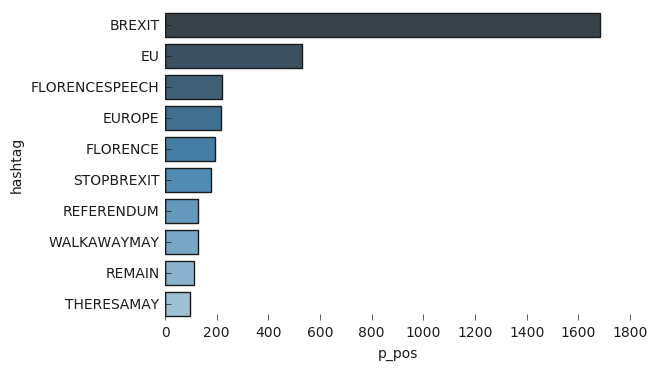

In [20]:
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="count", y="hashtag", data=analysis1,
            label="Total", palette="Blues_d")
sns.set_color_codes("pastel")
sns.barplot(x="p_pos", y="hashtag", data=analysis1,
            label="Total", palette="Blues_d")
sns.despine(left=True, bottom=True)

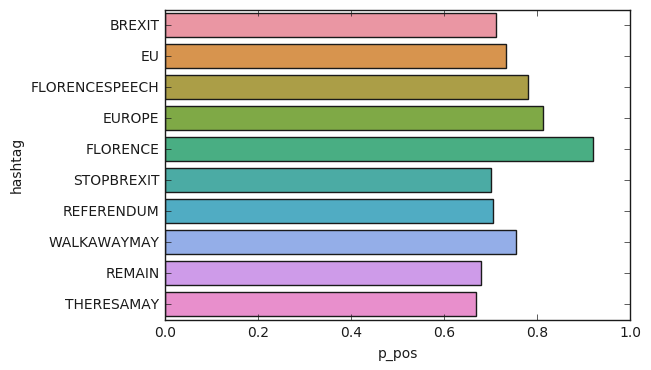

In [21]:
sns.set_color_codes("pastel")
sns.barplot(x="p_pos", y="hashtag", data=analysis1,
            label="Total")

<h3>Analysis 2: the number of bot</h3>
Distribution Plot below show the number of bots. where value above 0.5 is suspected as a bot.
but it seems the human still dominate the twitter, since the median falling around between 0.3 and 0.4. but there is a Zero value of botometer, since the user is not found. but they exist during the data time frame. Are they only activate their account during that time? are they human or bot? or are they already indetified as bot by twitter and then the got banned?

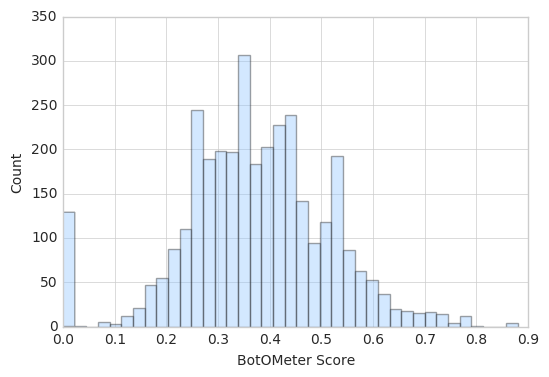

In [22]:
sns.set_style("whitegrid")
ax=sns.distplot(compiled_data['botometer'], kde=False)
ax.set_xlabel("BotOMeter Score")
ax.set_ylabel("Count")

<h3>Analysis 3: Sentiment on the timeline</h3>
As it can be seen, there is a lot of the number of positive sentiment rather than the negative sentiment. and they reach a peak at 12:31 PM. 

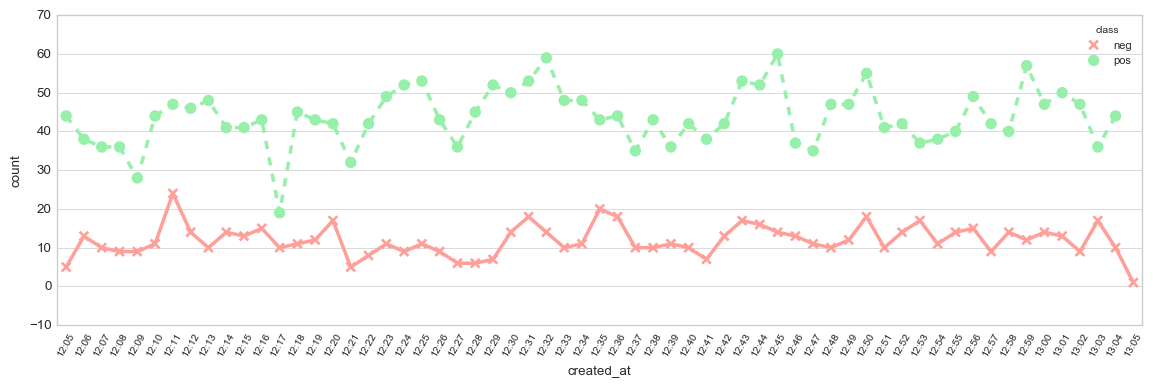

In [23]:
dims = (14, 4)
fig, axarr = plt.subplots(figsize=dims)
new_labels = ['created_at', 'class']
ii=0

time_analysis=pd.DataFrame({
            'created_at':compiled_data['created_at'].dt.strftime('%H:%M'),
            'class':compiled_data['class'],
            'count':range(len(compiled_data))
            })

time_analysis=time_analysis.groupby(['created_at', 'class'], as_index=False).count()
#time_analysis.head()

sns.set()
sns.set_context("paper")
#sns.set_style("darkgrid", {'xtick.direction': u'out'})
g=sns.pointplot(x="created_at", y="count", hue='class', data=time_analysis,
              palette={"neg": "r", "pos": "g"},
              markers=["x", "o"], linestyles=["-", "--"],
              ax=axarr, scales=0.7, aspect=9.0
             )

for item in g.get_xticklabels():
    item.set_rotation(60)
    item.set_size(7.5)


<h3>Analysis 4: Are the bot spread the positivity or the negativity</h3>

As it can be seen, the positive sentiment tweets dominate the conversation during the time frame. based on the column "class", positive sentiments fall for the p_pos above 0.5. where negative sentiment fall below 0.5. and there is a linear positive correlation between positive tweet and the botmeter value. on the other hand, there is a slight neagative correlation between negative tweet and botometer.

(-0.05, 0.95)

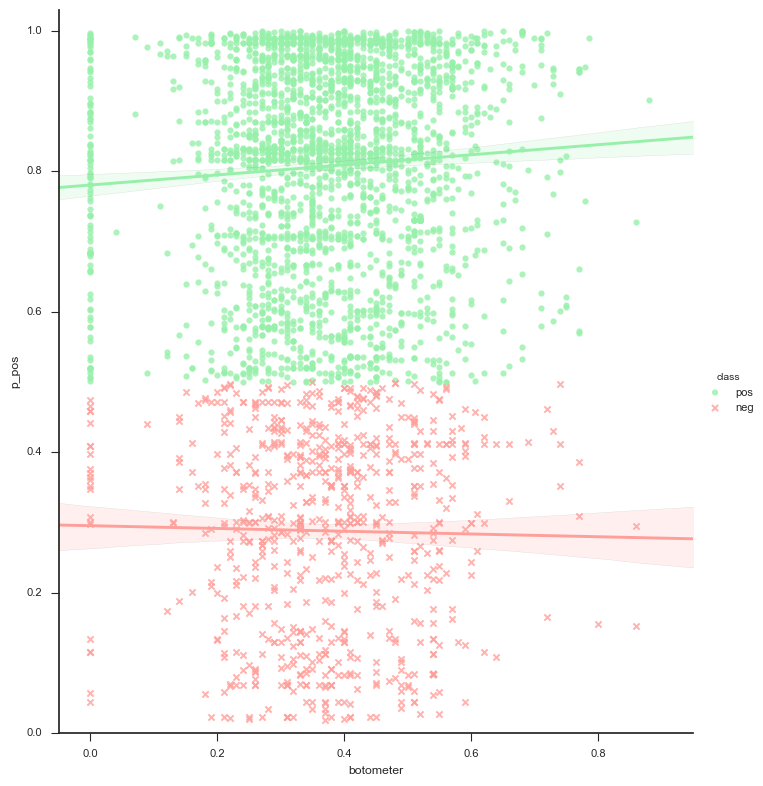

In [24]:

sns.set(style="ticks")
sns.set_context("paper")
y = sns.lmplot(x="botometer", y="p_pos", hue='class', data=compiled_data, 
               markers=["o", "x"],
               palette={"neg": "r", "pos": "g"},
               aspect=.9,
               size=8)
plt.ylim(0, 1.03) 
plt.xlim(-0.05, 0.95) 

<h1>Hypotheses</h1>

<h3>hypothesis #1:</h3>
Does the sentiment analysis in brexit like negative or positive exactly explain the context of the brexit?what is the meaning of positive sentiment in this case??

I think, before we say if this sentiment positive or not. we need to agree or decide in what context brexit tweet is positive sentiment or negative. when people say brexit in positive sentiment. is that mean when they leave the EU are they happy with that? or they happy when not leave the EU. I think we need to put a context in this case.


Further work, By using 

<h3>hypothesis #2:</h3>
Does one hour frame enough to provide the insight?

in order to know the chronology or the spread of thought the data should not only one hour time frame. it's supposed to be more than one hour time frame. as we can see on column retweeted_count, quoted_count, reply_count, there is no value on it. it might occurs in the next hours or day. so we can see, how is the impact of the tweet. and also to understand timeline of brexit we need to analyze more than one hour time frame, so we could see the timeline.

<h3>hypothesis #3:</h3>
Do the bot is matter? why we need to identify them?
I think we need to identify the bot since they taking part on the "discussion". just to make sure before we conclude that the insight is pure from human, we can identify there is a bot lie on the data.